In [1]:
import intake
import cartopy.crs as ccrs
import cmocean
import easygems.healpix as egh
import healpix
import matplotlib.pyplot as plt
import seaborn as sns

The three reanalysis datasets ERA5, JRA3Q, and MERRA2 are available via the NextGEMS data catalog.
Each dataset offers a complete [HEALPix hierarchy](https://easy.gems.dkrz.de/Processing/healpix/index.html), enabling faster data access depending on the type of analysis.

As a rule of thumb, the following zoom levels have proven to be useful:

Zoom | Analysis
--- | ---
0 | Global mean
6 | World maps
max(z) | Local timeseries

In [2]:
# WCRP Global Hackathon catalog
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")["online"]

# NextGEMS catalog
# cat = intake.open_catalog("https://data.nextgems-h2020.eu/online.yaml")

# Time Series
## Global mean

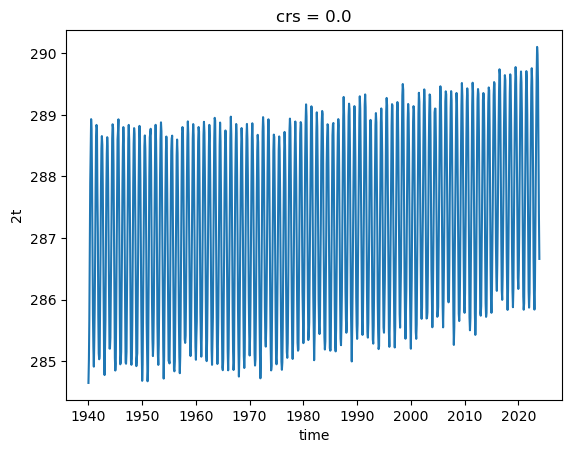

In [3]:
cat.ERA5(zoom=0).to_dask()["2t"].mean("cell").plot()

Here, we plot the global mean temperature from all three reanalyses.

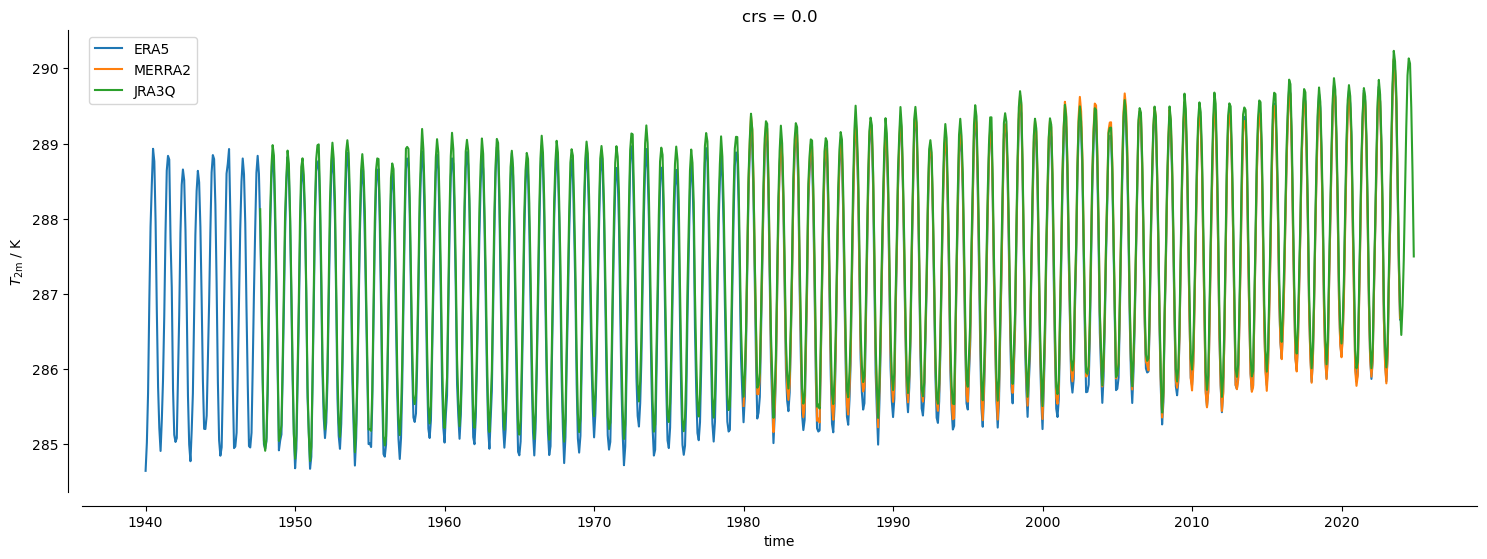

In [4]:
datasets = {
    "ERA5": cat.ERA5(zoom=0).to_dask()["2t"],
    "MERRA2": cat.MERRA2(zoom=0).to_dask()["t2m"],
    "JRA3Q": cat.JRA3Q(zoom=0).to_dask()["mean2t"],
}

fig, ax = plt.subplots(figsize=(18, 6))
for label, sst in datasets.items():
    sst.mean("cell").plot(label=label, ax=ax)
ax.legend()
ax.set_ylabel(r"$T_\mathrm{2m}$ / K")
sns.despine(offset=10)

## Hamburg

It is also possible to select a specific location (for example Hamburg) and plot the temperature timeseries for all reanalyses.

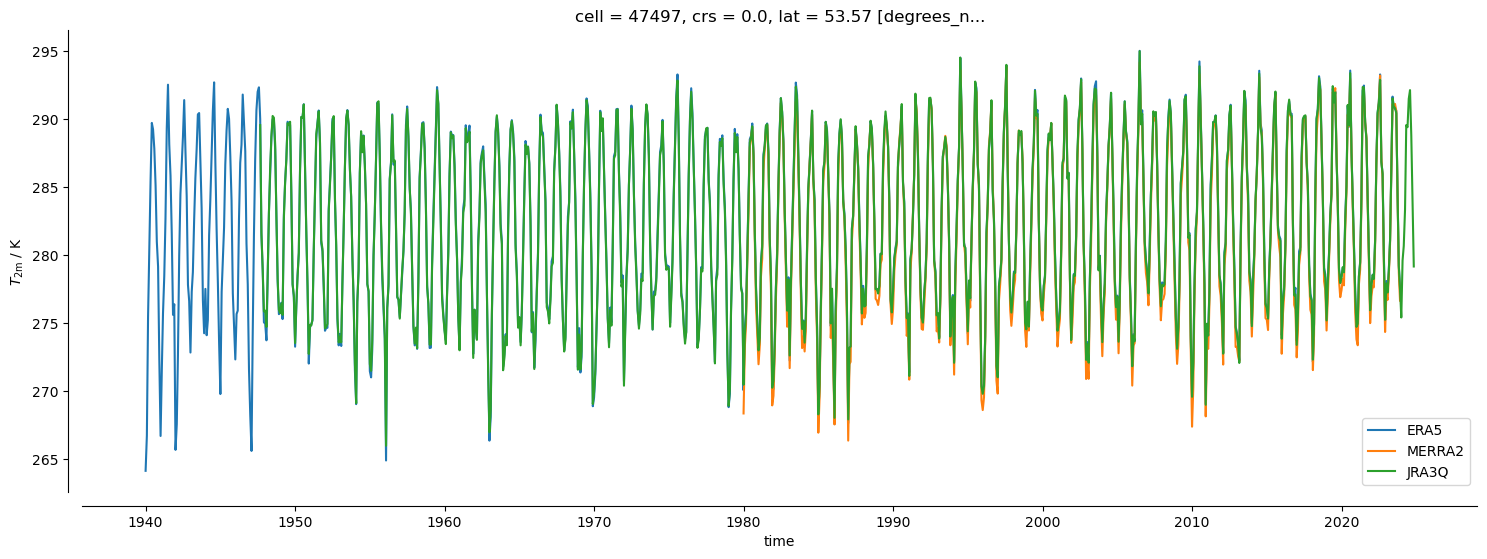

In [5]:
datasets = {
    "ERA5": cat.ERA5(zoom=8).to_dask()["2t"],
    "MERRA2": cat.MERRA2(zoom=7).to_dask()["t2m"],
    "JRA3Q": cat.JRA3Q(zoom=8).to_dask()["mean2t"],
}

fig, ax = plt.subplots(figsize=(18, 6))
for label, sst in datasets.items():
    hamburg = healpix.ang2pix(
        sst.crs.healpix_nside,
        9.993333,
        53.550556,
        lonlat=True,
        nest=sst.crs.healpix_nside,
    )
    sst.sel(cell=hamburg).plot(label=label, ax=ax)
ax.legend()
ax.set_ylabel(r"$T_\mathrm{2m}$ / K")
sns.despine(offset=10)

# Maps

## Comparison
To compare the spatial distribution, we can take the mean over time and plot the pattern on a map (here: precipitation).

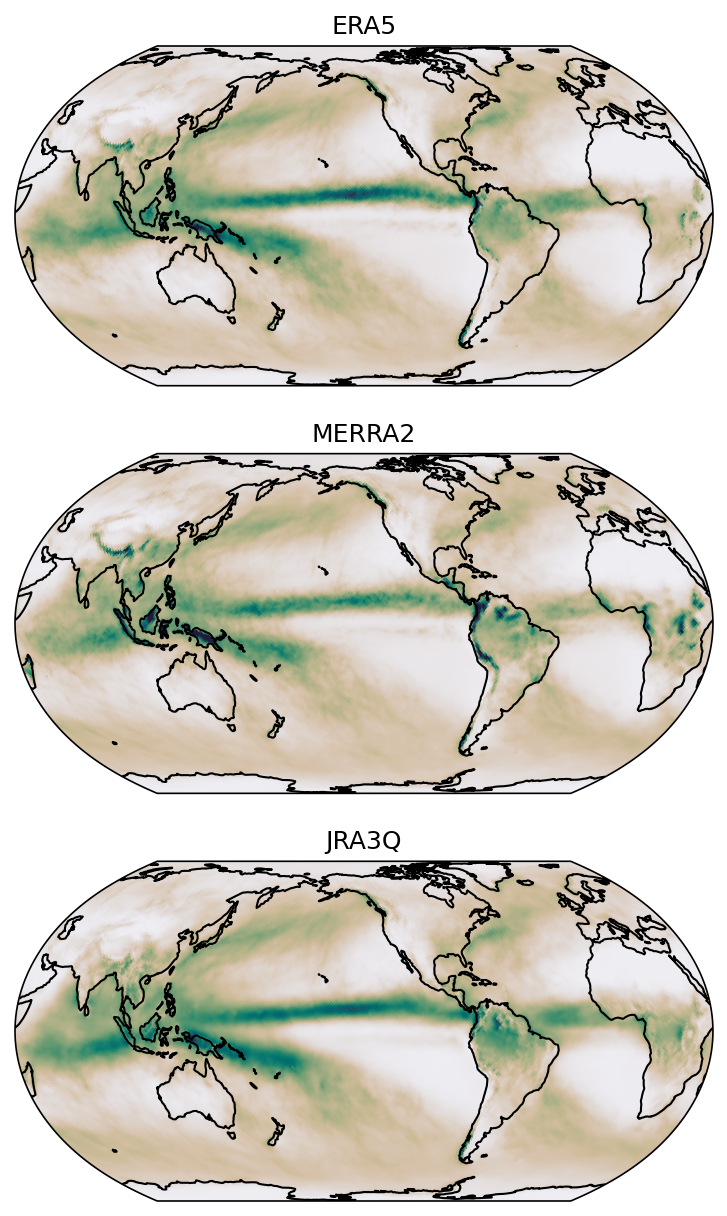

In [6]:
datasets = {
    "ERA5": cat.ERA5(zoom=6).to_dask()["tp"],
    "MERRA2": cat.MERRA2(zoom=6).to_dask()["prectot"] * 86.4,
    "JRA3Q": cat.JRA3Q(zoom=6).to_dask()["mtpr"] * 86.4,
}

fig, axes = plt.subplots(
    nrows=3,
    dpi=150,
    figsize=(6.4, 10),
    subplot_kw={"projection": ccrs.EqualEarth(-135.58)},
)
for (label, var), ax in zip(datasets.items(), axes):
    ax.set_global()
    ax.coastlines()
    egh.healpix_show(
        var.sel(time="2020").mean("time"), vmax=0.02, cmap="cmo.rain", ax=ax
    )
    ax.set_title(label)

## Differences

Since all reanalyses are on the same healpix zoom level it is also easy to plot the mean spatial differences between two of them in a given time range. Here: the mean differences in 2m temperature between JRA3Q and ERA5

Text(0.5, 1.0, 'JRA3Q - ERA5')

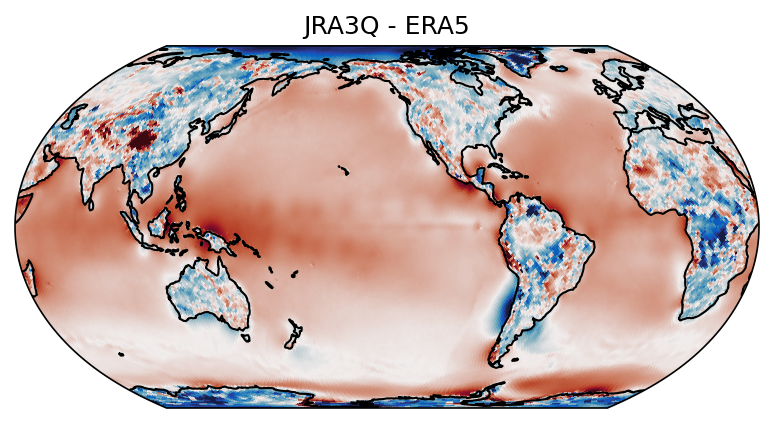

In [7]:
datasets = {
    "ERA5": cat.ERA5(zoom=6).to_dask()["2t"],
    "MERRA2": cat.MERRA2(zoom=6).to_dask()["t2m"],
    "JRA3Q": cat.JRA3Q(zoom=6).to_dask()["mean2t"],
}

diff = datasets["JRA3Q"] - datasets["ERA5"]

fig, ax = plt.subplots(dpi=150, subplot_kw={"projection": ccrs.EqualEarth(-135.58)})
ax.set_global()
ax.coastlines()
egh.healpix_show(
    diff.sel(time=slice("2000", "2020")).mean("time"),
    vmin=-2,
    vmax=2,
    cmap="cmo.balance",
    ax=ax,
)
ax.set_title("JRA3Q - ERA5")

# Derive new quantities

New quantities like the El-Niño 3.4 index can be calculated and plotted on the fly.

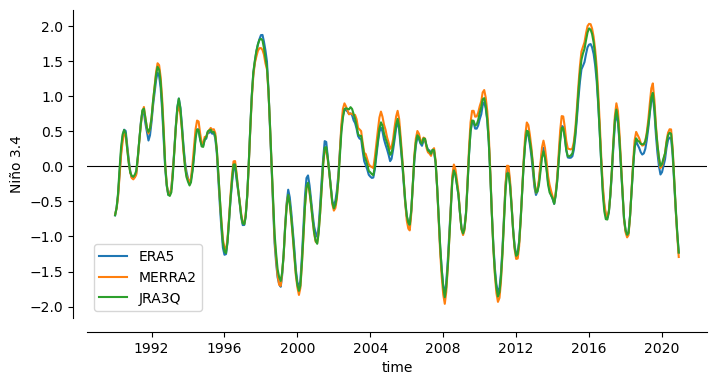

In [8]:
datasets = {
    "ERA5": cat.ERA5(zoom=5).to_dask().skt,
    "MERRA2": cat.MERRA2(zoom=5).to_dask().ts,
    "JRA3Q": cat.JRA3Q(zoom=5).to_dask().msst,
}

fig, ax = plt.subplots(figsize=(8, 4))
ax.axhline(0, color="k", linewidth=0.8)
for label, sst in datasets.items():
    # Spatial mean over Nino region
    nino34 = egh.isel_extent(sst, [-170, -120, -5, 5])
    sst = sst.sel(cell=nino34).mean("cell")

    # Compute anomaly to reference period
    sst_ref = sst.sel(time=slice("1991", "2000"))
    sst_anom = (sst - sst_ref.mean("time")) / sst_ref.std("time")

    # Plot smoothened Nino index values
    sst_anom.rolling(time=5).mean("time").sel(time=slice("1990", "2020")).plot(
        label=label, ax=ax
    )
ax.set_ylabel("Niño 3.4")

ax.legend()
ax.set_title("")
sns.despine(offset=10)

# 3D variables 
Some 3D variables like relative humidity are included, such that their dependency on latitude can be visualized easily.

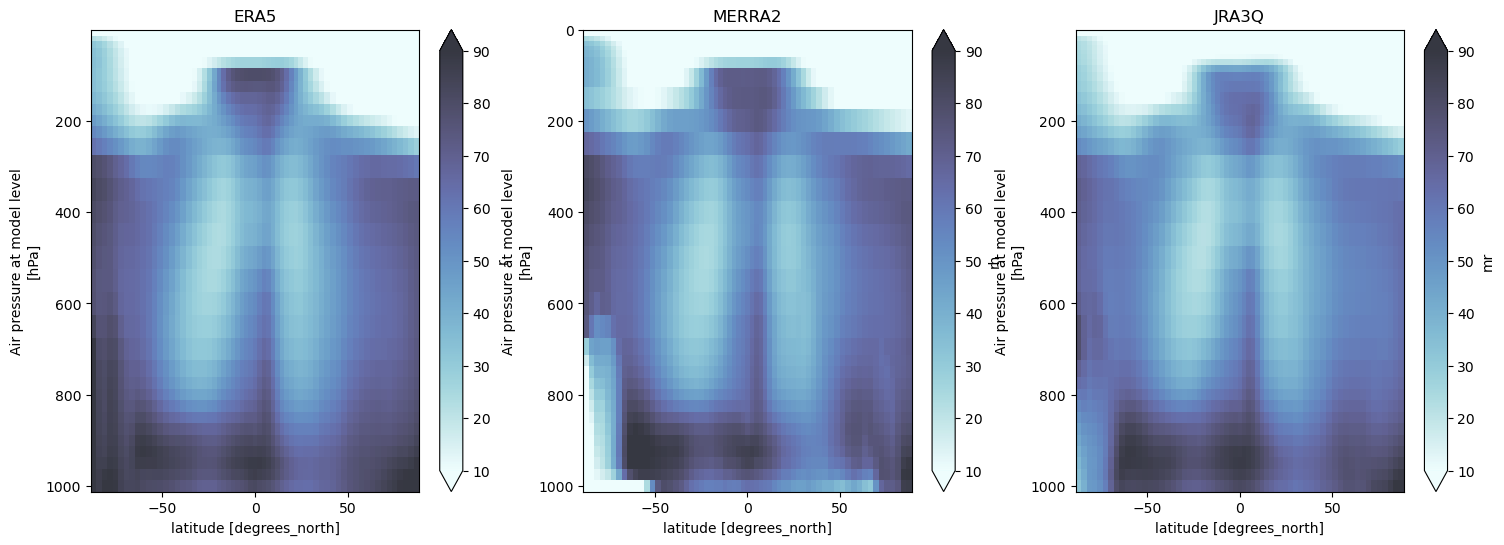

In [9]:
datasets = {
    "ERA5": cat.ERA5(zoom=4).to_dask().r,
    "MERRA2": cat.MERRA2(zoom=4).to_dask().rh * 100,
    "JRA3Q": cat.JRA3Q(zoom=4).to_dask().mr,
}

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

for (label, q), ax in zip(datasets.items(), axes):
    q = (
        q.sel(time="2010")
        .groupby("lat")
        .mean()
        .mean(["time"])
        .plot(ax=ax, vmin=10, vmax=90, x="lat", cmap="cmo.ice_r", alpha=0.8)
    )
    ax.invert_yaxis()
    ax.set_title(label)

# Resolution

ERA5 and JRA3Q also provide an finer zoom level of 8.

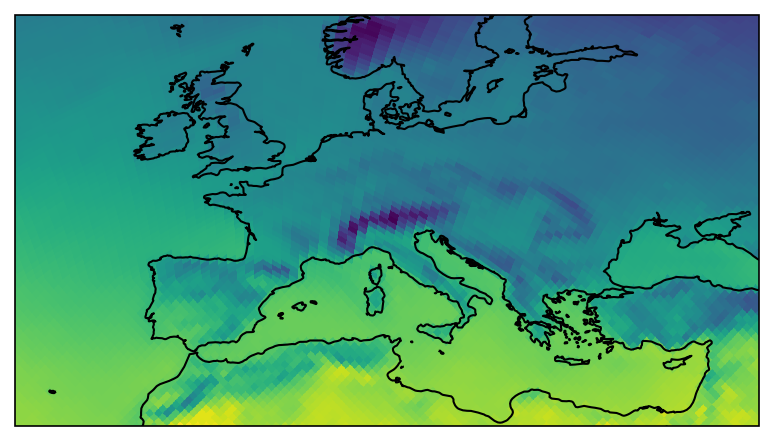

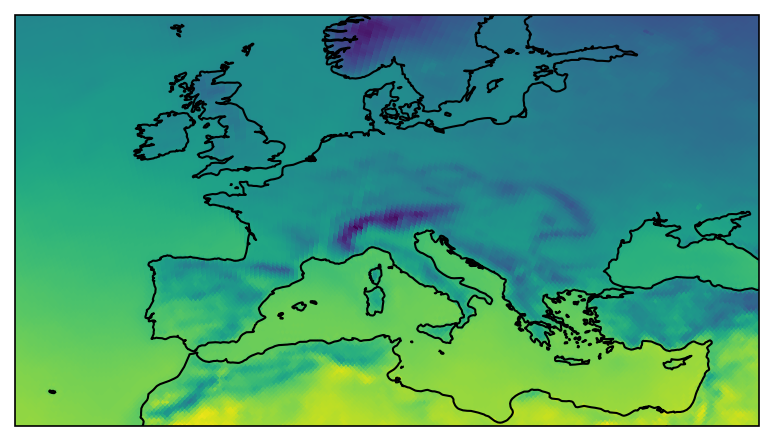

In [10]:
for z in (7, 8):
    ds = cat.ERA5(zoom=z).to_dask()

    fig, ax = plt.subplots(dpi=150, subplot_kw={"projection": ccrs.PlateCarree()})
    ax.set_extent([-20, 40, 30, 60])
    ax.coastlines()
    egh.healpix_show(ds["skt"].sel(time="1991").mean("time"))